In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.utils as vutils
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Set seed for reproducibility
torch.manual_seed(12345)

In [3]:
# The Encoder block for the VAE as recommended in the assignment
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 2, 1)
        self.fc = nn.Linear(4 * 4 * 256, 2 * latent_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# The Decoder block for the VAE as recommended in the assignment
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 4 * 4 * 256)
        self.tconv1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.tconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.tconv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.conv_out = nn.Conv2d(32, 1, 3, 1, 1)

    def forward(self, x):
        x = self.fc(x)
        x = torch.relu(x)
        x = x.view(x.size(0), 256, 4, 4)
        x = torch.relu(self.tconv1(x))
        x = torch.relu(self.tconv2(x))
        x = torch.relu(self.tconv3(x))
        x = self.conv_out(x)
        return torch.sigmoid(x)  # Apply sigmoid activation to keep values between 0 and 1

# Define the VAE model with the Encoder and Decoder blocks
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        # Get mean and logvar from the encoder
        z_mean_logvar = self.encoder(x)
        
        # Unpack the mean and logvar into two separate varaibles
        z_mean, z_logvar = torch.chunk(z_mean_logvar, 2, dim=1)
        
        # Reparameterization trick to sample from the approximate posterior
        epsilon = torch.randn_like(z_mean)
        z = z_mean + torch.exp(0.5 * z_logvar) * epsilon
        
        # Obtain the reconstructed input from the decoder
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_logvar

# Define the ELBO loss function
def loss_function(x_recon, x, z_mean, z_logvar):
    # Reconstruction loss uses binary cross entropy
    reconstruction_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    
    # KL-divergence implementation (signed as a negative)
    kl_divergence = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    
    # Subtract KL-divergence from the reconstruction loss to obtain "full-negative ELBO"
    return reconstruction_loss + kl_divergence

In [4]:
# Define the latent dimension to be 16 as recommended
latent_dim = 16

# Create an instance of the VAE
vae = VAE(latent_dim=latent_dim)

# Define the optimizer and use a learning rate of 0.001 as recommended
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Define the transformation to bring it to the proper dimensionality
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# Load the training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

# Load the testing dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Set the number of epochs, and initialize arrays to store our train loss histories
num_epochs = 10
elbo_loss_history = []
kl_div_history = []
recon_loss_history = []

batch_elbo_loss_history = []
batch_kl_div_history = []
batch_recon_loss_history = []

# Initialize arrays to store test loss histories
test_elbo_loss_history = []
test_kl_div_history = []
test_recon_loss_history = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to train
    vae.train()
    
    # Record our total loss per epoch
    total_elbo_loss = 0
    total_kl = 0
    total_recon = 0
    
    # Loop through our batches
    for batch_idx, (data, _) in enumerate(train_loader):
        
        # Print out batch numbers periodically to ensure the training is working
        if batch_idx % 100 == 0:
            print(batch_idx)
        optimizer.zero_grad()
        
        # Get outputs from our model
        recon_batch, z_mean, z_logvar = vae(data)
        
        # Get our ELBO loss, as well as specifically our reconstruction loss and KL-divergence (for the minibatch)
        elbo_loss = loss_function(recon_batch, data, z_mean, z_logvar)
        batch_recon = nn.functional.binary_cross_entropy(recon_batch, data, reduction='sum')
        batch_kl = 0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        
        # Backpropagation
        elbo_loss.backward()
        
        # Add the minibatch losses to the by-epoch losses
        total_elbo_loss += elbo_loss.item()
        total_kl += batch_kl.item()
        total_recon += batch_recon.item()
        
        batch_elbo_loss_history.append(elbo_loss.item())
        batch_kl_div_history.append(batch_kl.item())
        batch_recon_loss_history.append(batch_recon.item())
        
        optimizer.step()

    # Record our average metrics for each type of loss/punishment
    avg_elbo_loss = total_elbo_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon / len(train_loader.dataset)
    avg_kl_div = total_kl / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Train ELBO Loss: {avg_elbo_loss:.4f}')
    print(f"Average Train Reconstruction Loss: {avg_recon_loss:.4f}")
    print(f"Average Train KL-Divergence: {avg_kl_div:.4f}")
    
    # Add the epoch-wise losses to our loss histories
    elbo_loss_history.append(avg_elbo_loss)
    kl_div_history.append(avg_kl_div)
    recon_loss_history.append(avg_recon_loss)

    # Testing loop (after the training loop)
    vae.eval()  # Set the model to evaluation mode

    # Record test loss metrics
    total_test_elbo_loss = 0
    total_test_kl = 0
    total_test_recon = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for batch_idx, (test_data, _) in enumerate(test_loader):
            test_recon_batch, test_z_mean, test_z_logvar = vae(test_data)
            test_elbo_loss = loss_function(test_recon_batch, test_data, test_z_mean, test_z_logvar)
            test_batch_recon = nn.functional.binary_cross_entropy(test_recon_batch, test_data, reduction='sum')
            test_batch_kl = 0.5 * torch.sum(1 + test_z_logvar - test_z_mean.pow(2) - test_z_logvar.exp())

            total_test_elbo_loss += test_elbo_loss.item()
            total_test_kl += test_batch_kl.item()
            total_test_recon += test_batch_recon.item()

    # Calculate average test loss metrics
    avg_test_elbo_loss = total_test_elbo_loss / len(test_loader.dataset)
    avg_test_recon_loss = total_test_recon / len(test_loader.dataset)
    avg_test_kl_div = total_test_kl / len(test_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Test ELBO Loss: {avg_test_elbo_loss:.4f}')
    print(f"Average Test Reconstruction Loss: {avg_test_recon_loss:.4f}")
    print(f"Average Test KL-Divergence: {avg_test_kl_div:.4f}")

    # Add test loss metrics to history arrays
    test_elbo_loss_history.append(avg_test_elbo_loss)
    test_kl_div_history.append(avg_test_kl_div)
    test_recon_loss_history.append(avg_test_recon_loss)

0
100
200
300
400
Epoch [1/10], Average Train ELBO Loss: 208.8434
Average Train Reconstruction Loss: 193.6025
Average Train KL-Divergence: -15.2409
Epoch [1/10], Average Test ELBO Loss: 156.3303
Average Test Reconstruction Loss: 133.0518
Average Test KL-Divergence: -23.2784
0
100
200
300
400
Epoch [2/10], Average Train ELBO Loss: 153.7524
Average Train Reconstruction Loss: 130.6669
Average Train KL-Divergence: -23.0855
Epoch [2/10], Average Test ELBO Loss: 150.8284
Average Test Reconstruction Loss: 127.4281
Average Test KL-Divergence: -23.4004
0
100
200
300
400
Epoch [3/10], Average Train ELBO Loss: 149.9470
Average Train Reconstruction Loss: 126.4619
Average Train KL-Divergence: -23.4852
Epoch [3/10], Average Test ELBO Loss: 148.0795
Average Test Reconstruction Loss: 124.7980
Average Test KL-Divergence: -23.2815
0
100
200
300
400
Epoch [4/10], Average Train ELBO Loss: 148.0485
Average Train Reconstruction Loss: 124.3960
Average Train KL-Divergence: -23.6525
Epoch [4/10], Average Test 

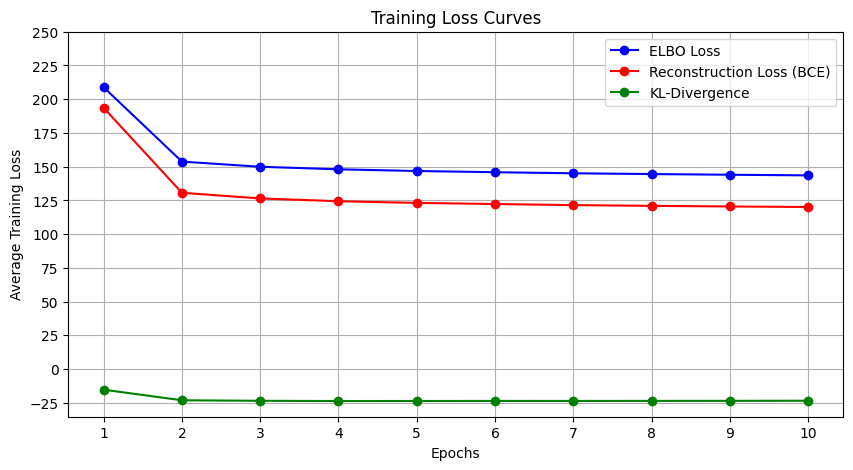

In [5]:
# Plot the loss history for our training dataset
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs + 1), elbo_loss_history, marker='o', c='blue', label='ELBO Loss')
plt.plot(np.arange(1, num_epochs + 1), recon_loss_history, marker='o', c='red', label='Reconstruction Loss (BCE)')
plt.plot(np.arange(1, num_epochs + 1), kl_div_history, marker='o', c='green', label='KL-Divergence')
plt.title('Training Loss Curves')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Average Training Loss')
plt.yticks(np.arange(-25,275,25))
plt.legend()
plt.grid(True)
plt.savefig('training_loss_curve_final.png')

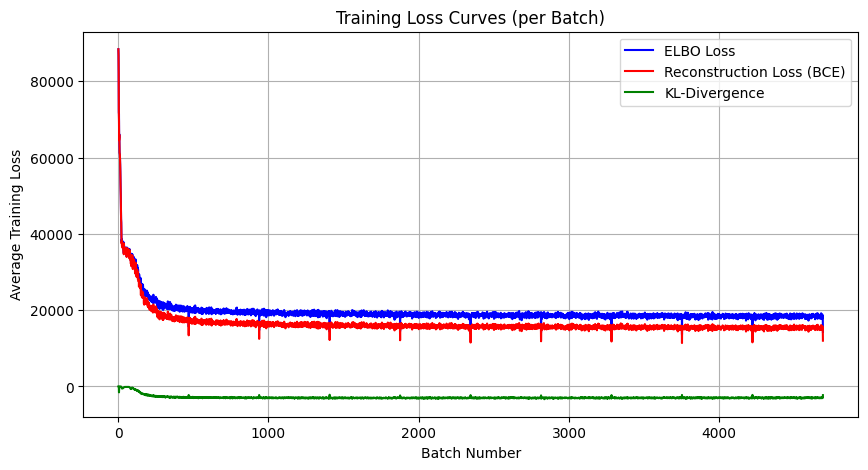

In [12]:
# Plot the loss history for our training dataset
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(batch_elbo_loss_history)+1), batch_elbo_loss_history, c='blue', label='ELBO Loss')
plt.plot(np.arange(1, len(batch_elbo_loss_history)+1), batch_recon_loss_history, c='red', label='Reconstruction Loss (BCE)')
plt.plot(np.arange(1, len(batch_elbo_loss_history)+1), batch_kl_div_history, c='green', label='KL-Divergence')
plt.title('Training Loss Curves (per Batch)')
plt.xlabel('Batch Number')
# plt.xticks(np.arange(1,11,1))
plt.ylabel('Average Training Loss')
# plt.yticks(np.arange(-25,275,25))
plt.legend()
plt.grid(True)
plt.savefig('batch_training_loss_curve_final.png')

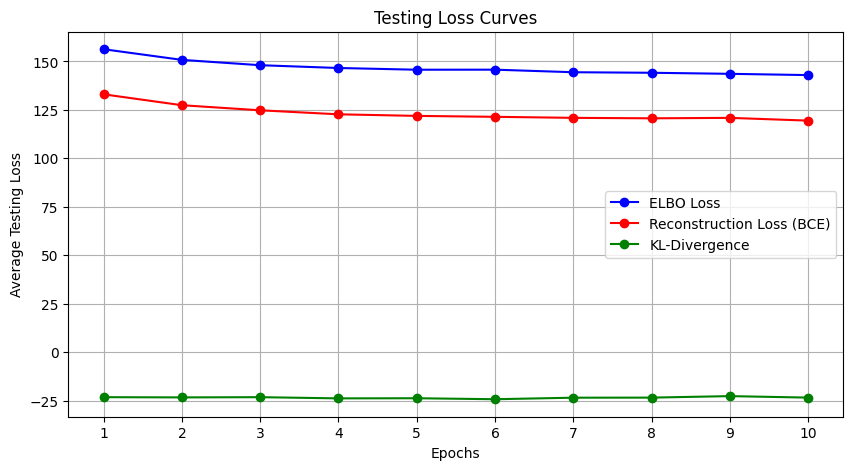

In [7]:
# Plot the loss history for our testing dataset
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs + 1), test_elbo_loss_history, marker='o', c='blue', label='ELBO Loss')
plt.plot(np.arange(1, num_epochs + 1), test_recon_loss_history, marker='o', c='red', label='Reconstruction Loss (BCE)')
plt.plot(np.arange(1, num_epochs + 1), test_kl_div_history, marker='o', c='green', label='KL-Divergence')
plt.title('Testing Loss Curves')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Average Testing Loss')
plt.yticks(np.arange(-25,175,25))
plt.legend()
plt.grid(True)
plt.savefig('testing_loss_curve_final.png')

In [8]:
# Set the VAE to evaluation mode. We will be finding out the final test set losses
vae.eval()
test_loss = 0
test_recon_loss = 0
test_kl_div = 0

with torch.no_grad():
    for data, _ in test_loader:
        recon_batch, z_mean, z_logvar = vae(data)
        test_loss += loss_function(recon_batch, data, z_mean, z_logvar).item()
        test_recon_loss += nn.functional.binary_cross_entropy(recon_batch, data, reduction='sum')
        test_kl_div += 0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())

avg_test_loss = test_loss / len(test_loader.dataset)
test_recon_loss = test_recon_loss / len(test_loader.dataset)
test_kl_div = test_kl_div / len(test_loader.dataset)
print(f'Final Test Set Performance - Average Test Set ELBO Loss: {avg_test_loss:.4f}')
print(f'Final Test Set Performance - Average Test Set Reconstruction Loss: {test_recon_loss:.4f}')
print(f'Final Test Set Performance - Average Test Set KL-Divergence: {test_kl_div:.4f}')

Final Test Set Performance - Average Test Set ELBO Loss: 142.9537
Final Test Set Performance - Average Test Set Reconstruction Loss: 119.4518
Final Test Set Performance - Average Test Set KL-Divergence: -23.5019


In [9]:
# Generate samples from the VAE
vae.eval()
with torch.no_grad():
    # Generate random noise, with shape compatible for our decoder
    z_samples = torch.randn(100, latent_dim)
    
    # Pass the random noise through the decoder to generate samples
    generated_samples = vae.decoder(z_samples)

# Create a 10x10 grid of generated samples
vutils.save_image(generated_samples, 'generated_samples_final.png', nrow=10, normalize=True)

In [10]:
# Generate real-image/reconstruction pairs
vae.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))  # Get a batch of test data
    
    # Pass the data through the full VAE to get the reconstructions
    recon_batch, _, _ = vae(data)
    
    # Create our pairings
    real_recon_pairs = torch.cat([data[:25], recon_batch[:25]])

# Create a 25x2 grid of real-image/reconstruction pairs
vutils.save_image(real_recon_pairs, 'real_recon_pairs_final.png', nrow=25, normalize=True)

In [11]:
# Generate interpolations
vae.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))  # Get a batch of test data

    interpolations = []
    for i in range(10):
        start, end = data[i], data[i+1]
        
        # Encode the start and end data points
        z_start = vae.encoder(start.unsqueeze(0))
        z_mean_start, z_logvar_start = torch.chunk(z_start, 2, dim=1)
        z_end = vae.encoder(end.unsqueeze(0))
        z_mean_end, z_logvar_end = torch.chunk(z_end, 2, dim=1)

        # Perform linear interpolation in the latent space
        alpha = torch.linspace(0, 1, steps=10).to(z_mean_start.device)
        
        # Compute interpolated latent vectors
        z_interp = (1 - alpha[:, None]) * z_mean_start + alpha[:, None] * z_mean_end
        
        # Generate the interpolations using our Decoder
        for t in range(10):
            interp_img = vae.decoder(z_interp[t].unsqueeze(0)).squeeze(0)
            interpolations.append(interp_img)

# Create a grid of interpolations, with each row being one
vutils.save_image(torch.stack(interpolations), 'interpolations_final.png', nrow=10, normalize=True)